In [77]:
### Code Header ###
# Project Name: Fashion Products Image Classification
# Dataset(s) : 1) Fashion MNIST dataset
# Date: 06/05/2020
# Author: Vallabh Reddy Burla
# Objective: Build an image classifier to identify the category of fashion product by taking the image as input
# Workflow: 
        # Import dataset
        # Data health, data cleaning
        # EDA
        # CNN
# Edits to be made:
# Features to add:


# Content
- [Acknowledgements](#acknowledgements)
- [Package Importing](#package-import)
- [About the Project](#about-project)
- [Loading the Data](#load-data)
- [Building the Model](#build-model)


# Acknowledgements <a class = 'anchor' id = 'acknowledgements'></a>
1. [Fashion MNIST dataset by Zalando Research](https://github.com/zalandoresearch/fashion-mnist)

# Package Importing <a class= 'anchor' id ='package-import'></a>

In [78]:
# Maching Learning 
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
import tensorflow as tf
from tensorflow import keras
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Input, Dense, Conv2D, Flatten, MaxPool2D, Dropout, BatchNormalization
from keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.python.client import device_lib
from tensorflow.python.keras.optimizers import Adam

# Visualization Libraries
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
from plotly.subplots import make_subplots
%matplotlib inline


# Wrangling Libraries
import pandas as pd
import numpy as np
from collections import Counter


# Image processing
from skimage.filters import threshold_otsu
from skimage.feature import canny




In [79]:
# Setting seed
np.random.seed(1993)

# Setting tensorflow seed
tf.set_random_seed(1993)

# About the Project <a class = 'anchor' id = 'about-project'></a>
The purpose of this project is to try out different image classification techniques and compare their performances on the Fashion-MNIST dataset which contains images of fashion products and their labels.

Neural Networks are known to perform really well in this field of classification, so we will be trying out different setups of these networks.


# Loading Fashion-MNIST<a class='anchor' id = 'load-data'></a>
We load the Fashion-MNIST dataset which is inbuilt into Keras. This dataset contains fashion product images in the form of a 28x28 numpy array where each cell ranges from 0 to 255 signifying the darkness of the pixel. The images are in grayscale.

There are 60,000 observations in the training dataset and 10,000 in the test set.

In [80]:
(train_images, train_labels), (test_images, test_labels) = keras.datasets.fashion_mnist.load_data()
y_train = train_labels
y_test = test_labels

In [81]:
set(test_labels)

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}

In [82]:
train_images.shape

(60000, 28, 28)

In [83]:
train_labels.shape

(60000,)

In [84]:
test_images.shape

(10000, 28, 28)

In [85]:
test_labels.shape

(10000,)

In [86]:
test_labels[:10]

array([9, 2, 1, 1, 6, 1, 4, 6, 5, 7], dtype=uint8)

Since these labels are in fact indexes, I'm creating a list of labels to extract the class name corresponding to the index.

In [87]:
label_names = ['T-shirt/top','Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot']

Let's convert label names from indexes to the actual names for convenience

In [88]:
train_labels = [label_names[x] for x in train_labels]
test_labels = [label_names[x] for x in test_labels]

Let's check the counts for each category of product in the test and train set

In [89]:
Counter(train_labels)

Counter({'Ankle Boot': 6000,
         'T-shirt/top': 6000,
         'Dress': 6000,
         'Pullover': 6000,
         'Sneaker': 6000,
         'Sandal': 6000,
         'Trouser': 6000,
         'Shirt': 6000,
         'Coat': 6000,
         'Bag': 6000})

In [90]:
Counter(test_labels)

Counter({'Ankle Boot': 1000,
         'Pullover': 1000,
         'Trouser': 1000,
         'Shirt': 1000,
         'Coat': 1000,
         'Sandal': 1000,
         'Sneaker': 1000,
         'Dress': 1000,
         'Bag': 1000,
         'T-shirt/top': 1000})

Note that each category has the exact same number of observations in both the test and train datasets.

Let's take a look at the first observation in our image matrix.

In [91]:
train_images[0]

array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   1,
          0,   0,  13,  73,   0,   0,   1,   4,   0,   0,   0,   0,   1,
          1,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   3,
          0,  36, 136, 127,  62,  54,   0,   0,   0,   1,   3,   4,   0,
          0,   3],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   6,
          0, 102, 204, 176, 134, 144, 123,  23,   0,   0,   0,   0,  12,
         10,   0],
       [  

Note that this is not actually a picture, but in fact a numpy array of pixel values.These the pixel values range from 0 - 255. It is common practice to scale these values to range between 0 and 1, in part because larger integer inputs can slow down a neural network and in part to standardize the input.

In [92]:
train_images = train_images/255
test_images = test_images/255

In [93]:
train_images[0]

array([[0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.    

#### Image Display

We've seen the image as a matrix representation, but that's not intuitive to us. It is a representation of an image, so we should be able to display it as a picture. We do so below along with the labels for the first 20 observations in the training set.

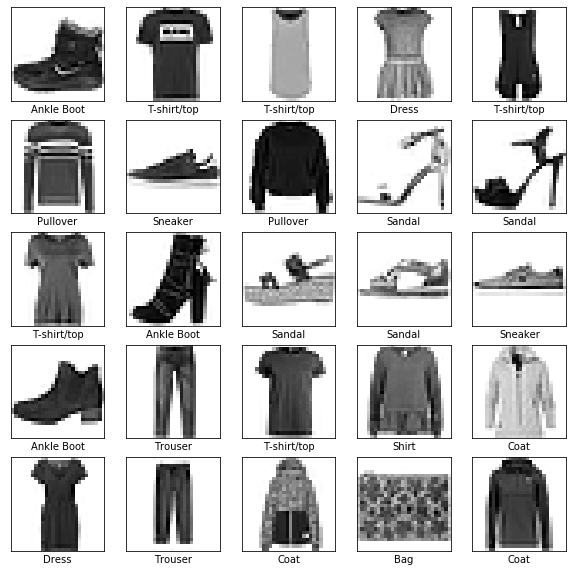

In [94]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(train_images[i], cmap = plt.cm.binary)
    plt.xlabel(train_labels[i])
plt.show() 

#### Pixel Density Distributions

Let's look at the pixel distribution for these images

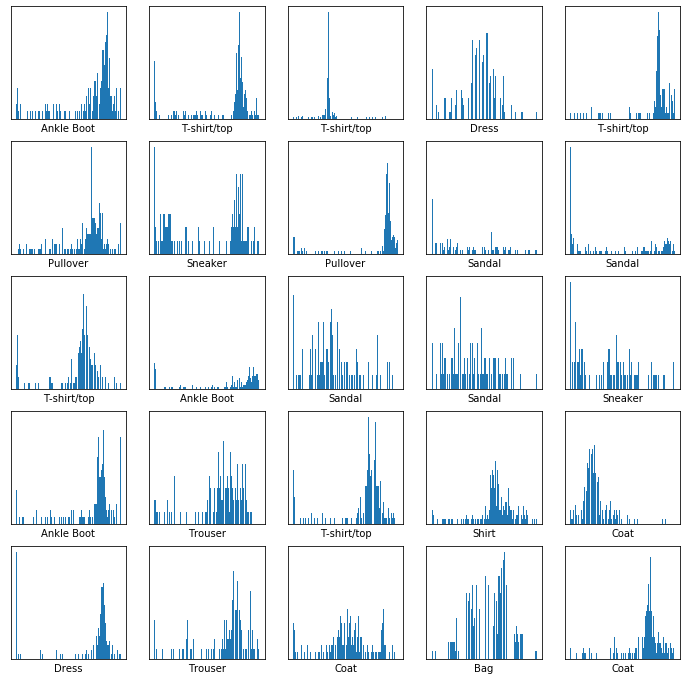

In [95]:
plt.figure(figsize=(12,12))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.hist(train_images[i][train_images[i]!=0].ravel(), bins = 256)
    plt.xlabel(train_labels[i])
plt.show() 

#### Thresholding

Thresholding converts pixels to either 255(black) or 0(white) based on whether they are greater than a certain threshold value or not.

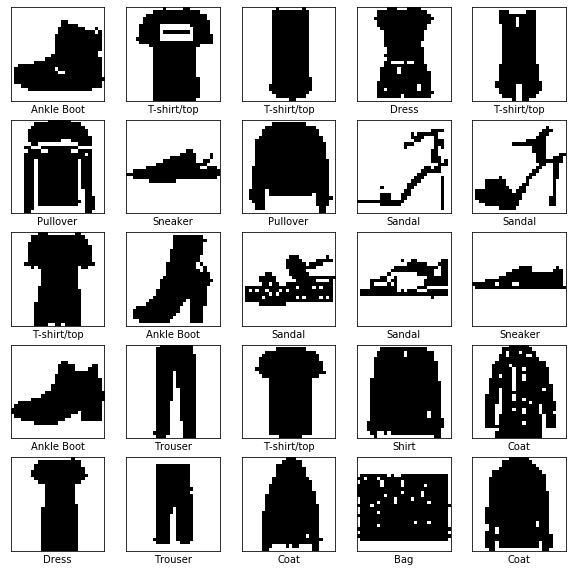

In [96]:
plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    thresh = threshold_otsu(train_images[i])
    post_thresh = train_images[i] > thresh
    plt.imshow(post_thresh, cmap = plt.cm.binary)
    plt.xlabel(train_labels[i])
plt.show() 


#### Edge Detection

Edge detection identifies the outlines of the important features in the image.

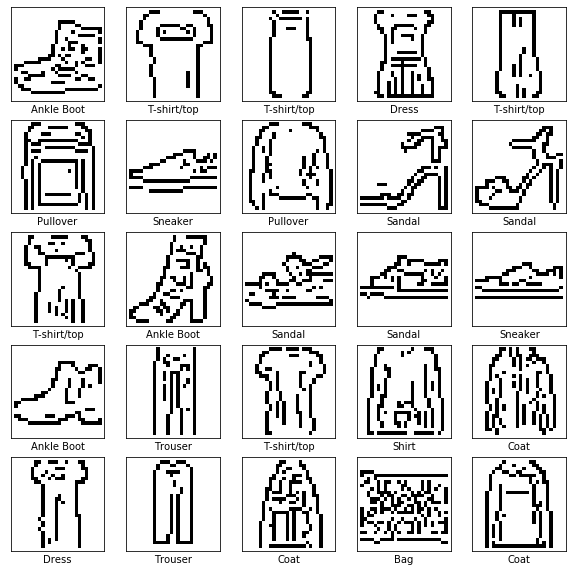

In [97]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(canny(train_images[i], 0.001), cmap = plt.cm.binary)
    plt.xlabel(train_labels[i])
plt.show()

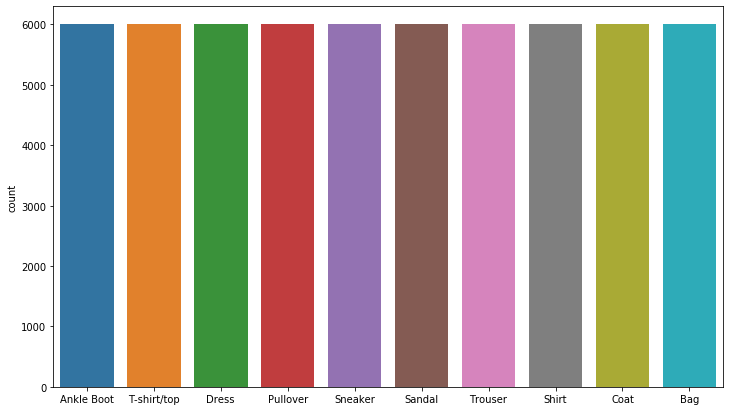

In [98]:
fig, ax = plt.subplots(figsize = (12,7))
ax = sns.countplot(x = train_labels)

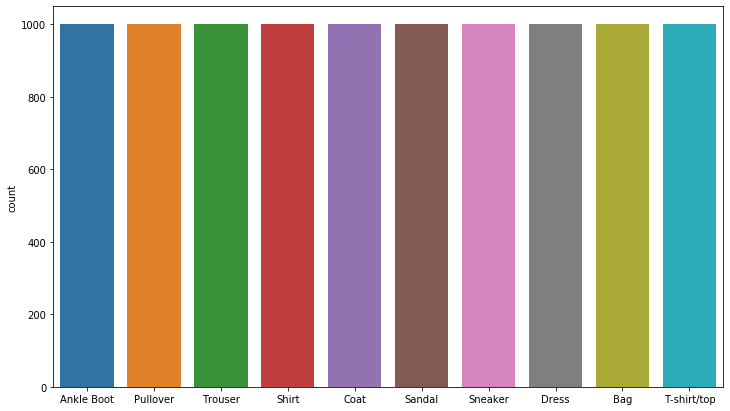

In [99]:
fig, ax = plt.subplots(figsize = (12,7))
ax = sns.countplot(x = test_labels)

We see that each category has the exact same number of observations in both the test and train data.

### Building the Model <a class='anchor' id = 'build-model'></a>

We must reshape the images to 3D tensors so that the CNN can interpret the images

In [100]:
train_images.shape

(60000, 28, 28)

In [101]:
X_train = np.reshape(train_images,(train_images.shape[0], train_images.shape[1], train_images.shape[2], 1))
X_test = np.reshape(test_images, (test_images.shape[0], test_images.shape[1], test_images.shape[2],1))

#### Model 1: 3 Convolutional, 3 Max pooling , 1 Output Layers with 25% dropout

In [26]:
model1 = Sequential([
    Conv2D(100, kernel_size = 3, padding = 'same', activation = 'relu', input_shape = (28,28,1))
    , Dropout(0.25)
    , MaxPool2D( pool_size = (2,2))
    , Conv2D(100, kernel_size = 3, padding = 'same', activation = 'relu')
    , Dropout(0.25)
    , MaxPool2D( pool_size = (2,2))
    , Conv2D(100, kernel_size = 3, padding = 'same', activation = 'relu')
    , Dropout(0.25)
    , MaxPool2D( pool_size = (2,2))
    , Flatten()
    , Dense (10, activation = 'softmax')
    
])


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


**Convolutional Layers (Conv2D)** - Try to look for the presence of certain patterns across the image. These patterns as represented by kernels which are trained as fitting goes on. So essentially, they learn the patterns they need to look for. As we stack multiple Conv2D layers, the patterns the network looks for get more complex.

**Pooling Layers (MaxPool2d)** - These summarise a small set of nearby pixels by averaging or taking the max value of the group. This essentially reduces the input size and thus reduces the total number of parameters to be trained.

**Dropout Layer (Dropout)** - These layers sever random connections between neurons equal to the percentage mentioned in the input. This is done to combat possible overfitting so that the network is not overly dependant on any particular feature that might have been an important telling feature only in the training set. It is forced to compensate and learn other differentiators.

**Flatten (Flatten)** - The convolutional layers have a 2 dimensional input and output, but the neural network layers need a one dimensional input. The flatten layer does just this, is takes the 2D input and flattens it to a 1D output which is fed to the neural network.

**Dense** - The dense layer has ten neurons, one each for each category of apparel. The 'softmax' activation function ensures that the sum of all probabilities equals to one.

In [27]:
model1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 100)       1000      
_________________________________________________________________
dropout (Dropout)            (None, 28, 28, 100)       0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 100)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 100)       90100     
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 100)       0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 100)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 100)         9

**Callbacks** 

*Early stopping* - Cuts short the training phase if the number of epochs without improvement to the loss crosses the patience value.

*Model Checkpoint* - If a model is trained for n number of epochs, it isn't necessary that the final model has the best performance. The model checkpoint callback saves the weights of the best model for use.


In [28]:
# Defining Callbacks

early_stopping_monitor = EarlyStopping(patience = 3)
model_checkpoint_monitor = ModelCheckpoint('model1.h5', monitor = 'val_loss', mode = 'min', save_best_only = True)

# Compile and fit

model1.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy' , metrics = ['accuracy'])
model1.fit(X_train, y_train, epochs = 5, validation_split = 0.2, callbacks = [early_stopping_monitor, model_checkpoint_monitor])

Train on 48000 samples, validate on 12000 samples
Epoch 1/5
48000/48000 [==============================] - 11s 238us/sample - loss: 0.4618 - acc: 0.8327 - val_loss: 0.4053 - val_acc: 0.8802
Epoch 2/5
48000/48000 [==============================] - 9s 178us/sample - loss: 0.3109 - acc: 0.8874 - val_loss: 0.3416 - val_acc: 0.8963
Epoch 3/5
48000/48000 [==============================] - 9s 178us/sample - loss: 0.2750 - acc: 0.8981 - val_loss: 0.2825 - val_acc: 0.9077
Epoch 4/5
48000/48000 [==============================] - 9s 179us/sample - loss: 0.2496 - acc: 0.9097 - val_loss: 0.2714 - val_acc: 0.9116
Epoch 5/5
48000/48000 [==============================] - 9s 179us/sample - loss: 0.2311 - acc: 0.9154 - val_loss: 0.2702 - val_acc: 0.9122


In [29]:
model1.load_weights('model1.h5')
model1.evaluate(X_test, y_test)

10000/10000 [==============================] - 1s 60us/sample - loss: 0.2825 - acc: 0.9067


[0.2824765396118164, 0.9067]

In the model summary for model 1, we see the input shape cutting down drastically because of multiple maxpooling layers. What started as (28, 28, 100) turns into (3, 3, 100). While maxpooling reduces the parameters required for training, I suspect these multiple layers might be oversimplifying the content, so let's try another network with only one max pooling layer.

#### Model 2: 3 Convolutional , 1 Max pooling, 1 Output Layers with 25% dropout

In [30]:
model2 = Sequential([
    Conv2D(100, kernel_size = 3, padding = 'same', activation = 'relu', input_shape = (28,28,1))
    , Dropout(0.25)
    , MaxPool2D( pool_size = (2,2))
    , Conv2D(100, kernel_size = 3, padding = 'same', activation = 'relu')
    , Dropout(0.25)
    , Conv2D(100, kernel_size = 3, padding = 'same', activation = 'relu')
    , Dropout(0.25)
    , Flatten()
    , Dense (10, activation = 'softmax')
    
])

In [31]:
model2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 28, 28, 100)       1000      
_________________________________________________________________
dropout_3 (Dropout)          (None, 28, 28, 100)       0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 14, 14, 100)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 14, 14, 100)       90100     
_________________________________________________________________
dropout_4 (Dropout)          (None, 14, 14, 100)       0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 14, 14, 100)       90100     
_________________________________________________________________
dropout_5 (Dropout)          (None, 14, 14, 100)      

The number of parameters is close to twice of what we had for the previous network, but the input dimensions are (14, 14, 100). Let's see if this performs better because we've left more detail in the input for the network to learn.

In [32]:
# Defining callbacks
early_stopping_monitor = EarlyStopping(patience = 3)
model_checkpoint_monitor = ModelCheckpoint('model2.h5', monitor = 'val_loss', mode = 'min', save_best_only = True)

# Compile and fit
model2.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
model2.fit(X_train, y_train, epochs = 5, validation_split = 0.2, callbacks = [early_stopping_monitor, model_checkpoint_monitor])


Train on 48000 samples, validate on 12000 samples
Epoch 1/5
48000/48000 [==============================] - 10s 212us/sample - loss: 0.4049 - acc: 0.8561 - val_loss: 0.3208 - val_acc: 0.8921
Epoch 2/5
48000/48000 [==============================] - 10s 207us/sample - loss: 0.2752 - acc: 0.9007 - val_loss: 0.2666 - val_acc: 0.9022
Epoch 3/5
48000/48000 [==============================] - 10s 207us/sample - loss: 0.2394 - acc: 0.9122 - val_loss: 0.2577 - val_acc: 0.9068
Epoch 4/5
48000/48000 [==============================] - 10s 207us/sample - loss: 0.2112 - acc: 0.9228 - val_loss: 0.2319 - val_acc: 0.9128
Epoch 5/5
48000/48000 [==============================] - 10s 207us/sample - loss: 0.1934 - acc: 0.9284 - val_loss: 0.2158 - val_acc: 0.9190


In [33]:
model2.load_weights('model2.h5')
model2.evaluate(X_test, y_test)

10000/10000 [==============================] - 1s 69us/sample - loss: 0.2344 - acc: 0.9177


[0.2343593897819519, 0.9177]

As expected we see that this network takes a marginally longer time to fit. There is a slight improvement, but we can't make a conclusion that dialing back the number of maxpool layers really helped. This is because the model performance might vary as using the GPU to train the models adds randomness which is not handled by setting the seed.

Let us use the second model and increase the number of epochs to see if that helps accuracy. 

#### Model 3: 3 Convolutional, 1 Max Pooling, 1 Output Layer - Dropout 25%, 20 epochs

In [34]:
model3 = Sequential([
    Conv2D(100, kernel_size = 3, padding = 'same', activation = 'relu', input_shape = (28,28,1))
    , Dropout(0.25)
    , MaxPool2D(pool_size = (2,2))
    , Conv2D(100, kernel_size = 3, padding = 'same', activation = 'relu')
    , Dropout(0.25)
    , Conv2D(100, kernel_size = 3, padding = 'same', activation = 'relu')
    , Dropout(0.25)
    , Flatten()
    , Dense(10, activation = 'softmax')
])

model3.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 28, 28, 100)       1000      
_________________________________________________________________
dropout_6 (Dropout)          (None, 28, 28, 100)       0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 14, 14, 100)       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 14, 14, 100)       90100     
_________________________________________________________________
dropout_7 (Dropout)          (None, 14, 14, 100)       0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 14, 14, 100)       90100     
_________________________________________________________________
dropout_8 (Dropout)          (None, 14, 14, 100)      

In [35]:
# Defining callbacks 
early_stopping_monitor = EarlyStopping(patience = 3)
model_checkpoint_monitor = ModelCheckpoint('model3.h5', monitor = 'val_loss', mode = 'min' , save_best_only = True)

# Compiling and fitting
model3.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
training = model3.fit(X_train, y_train, validation_split = 0.2, epochs = 20, callbacks = [early_stopping_monitor, model_checkpoint_monitor])

Train on 48000 samples, validate on 12000 samples
Epoch 1/20
48000/48000 [==============================] - 10s 215us/sample - loss: 0.4007 - acc: 0.8571 - val_loss: 0.2895 - val_acc: 0.8976
Epoch 2/20
48000/48000 [==============================] - 10s 214us/sample - loss: 0.2705 - acc: 0.9011 - val_loss: 0.2582 - val_acc: 0.9045
Epoch 3/20
48000/48000 [==============================] - 10s 208us/sample - loss: 0.2341 - acc: 0.9139 - val_loss: 0.2474 - val_acc: 0.9128
Epoch 4/20
48000/48000 [==============================] - 10s 208us/sample - loss: 0.2101 - acc: 0.9227 - val_loss: 0.2291 - val_acc: 0.9183
Epoch 5/20
48000/48000 [==============================] - 10s 208us/sample - loss: 0.1896 - acc: 0.9309 - val_loss: 0.2279 - val_acc: 0.9177
Epoch 6/20
48000/48000 [==============================] - 10s 207us/sample - loss: 0.1742 - acc: 0.9370 - val_loss: 0.2189 - val_acc: 0.9187
Epoch 7/20
48000/48000 [==============================] - 10s 208us/sample - loss: 0.1613 - acc: 0.9413 

In [36]:
model3.load_weights('model3.h5')
model3.evaluate(X_test, y_test)

10000/10000 [==============================] - 1s 68us/sample - loss: 0.2321 - acc: 0.9189


[0.23205117869973182, 0.9189]

Even though the number of epochs is higher, early stopping always seems to cut short the learning. Let's try reducing the learning rate of the optimizer.

#### Model 4: 3 Convolutional, 1 Max Pooling, 1 Output Layers - Dropout 25%, 20 epochs, Lower Learning Rate

In [37]:
model4 = Sequential([
    Conv2D(100, kernel_size = 3, padding = 'same', activation = 'relu', input_shape = (28,28,1))
    , Dropout(0.25)
    , MaxPool2D(pool_size = (2,2))
    , Conv2D(100, kernel_size = 3, padding = 'same', activation = 'relu')
    , Dropout(0.25)
    , Conv2D(100, kernel_size = 3, padding = 'same', activation = 'relu')
    , Dropout(0.25)
    , Flatten()
    , Dense(10, activation = 'softmax')
])

model4.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 28, 28, 100)       1000      
_________________________________________________________________
dropout_9 (Dropout)          (None, 28, 28, 100)       0         
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 14, 14, 100)       0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 14, 14, 100)       90100     
_________________________________________________________________
dropout_10 (Dropout)         (None, 14, 14, 100)       0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 14, 14, 100)       90100     
_________________________________________________________________
dropout_11 (Dropout)         (None, 14, 14, 100)      

In [38]:
# Defining callbacks 
early_stopping_monitor = EarlyStopping(patience = 3)
model_checkpoint_monitor = ModelCheckpoint('model4.h5', monitor = 'val_loss', mode = 'min' , save_best_only = True)

# Defining the optimizer 
adam = Adam(lr = 0.0001)
# Compiling and fitting
model4.compile(optimizer = adam, loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
training = model4.fit(X_train, y_train, validation_split = 0.2, epochs = 20, callbacks = [early_stopping_monitor, model_checkpoint_monitor])

Train on 48000 samples, validate on 12000 samples
Epoch 1/20
48000/48000 [==============================] - 11s 230us/sample - loss: 0.5815 - acc: 0.7923 - val_loss: 0.4431 - val_acc: 0.8422
Epoch 2/20
48000/48000 [==============================] - 11s 221us/sample - loss: 0.3928 - acc: 0.8619 - val_loss: 0.3869 - val_acc: 0.8661
Epoch 3/20
48000/48000 [==============================] - 11s 221us/sample - loss: 0.3457 - acc: 0.8781 - val_loss: 0.3425 - val_acc: 0.8847
Epoch 4/20
48000/48000 [==============================] - 11s 222us/sample - loss: 0.3095 - acc: 0.8902 - val_loss: 0.3051 - val_acc: 0.8920
Epoch 5/20
48000/48000 [==============================] - 11s 222us/sample - loss: 0.2855 - acc: 0.8982 - val_loss: 0.2952 - val_acc: 0.8954
Epoch 6/20
48000/48000 [==============================] - 11s 222us/sample - loss: 0.2649 - acc: 0.9049 - val_loss: 0.2727 - val_acc: 0.9018
Epoch 7/20
48000/48000 [==============================] - 11s 222us/sample - loss: 0.2496 - acc: 0.9100 

In [47]:
model4.load_weights('model4.h5')
model4.evaluate(X_test, y_test)

10000/10000 [==============================] - 1s 95us/sample - loss: 0.2161 - acc: 0.9252


[0.21608757364153863, 0.9252]

We get the same evaluation accuracy.

So far we have used a smaller network. We noted earlier that convolutions capture more complex features as we increase the depth. So let's try a deeper network with a higher number of layers and nodes.

#### Model 5: 4 Convolutional , 1 Max Pooling , 2 Hidden, 1 Output Layers - Dropout 25%,  20 epochs

In [60]:
model5 = Sequential([
    Conv2D(100, kernel_size = 3, padding = 'same', activation = 'relu', input_shape = (28,28,1))
    , Dropout(0.25)
    , MaxPool2D(pool_size = (2,2))
    , Conv2D(100, kernel_size = 3, padding = 'same', activation = 'relu')
    , Dropout(0.25)
    , Conv2D(100, kernel_size = 3, padding = 'same', activation = 'relu')
    , Dropout(0.25)
    , Conv2D(100, kernel_size = 3, padding = 'same', activation = 'relu')
    , Dropout(0.25)
    , Flatten()
    , Dense(200, activation = 'relu')
    , Dropout(0.25)
    , Dense(10, activation = 'softmax')
])
model5.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_32 (Conv2D)           (None, 28, 28, 100)       1000      
_________________________________________________________________
dropout_43 (Dropout)         (None, 28, 28, 100)       0         
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 14, 14, 100)       0         
_________________________________________________________________
conv2d_33 (Conv2D)           (None, 14, 14, 100)       90100     
_________________________________________________________________
dropout_44 (Dropout)         (None, 14, 14, 100)       0         
_________________________________________________________________
conv2d_34 (Conv2D)           (None, 14, 14, 100)       90100     
_________________________________________________________________
dropout_45 (Dropout)         (None, 14, 14, 100)      

In [61]:
# Defining callbacks 
early_stopping_monitor = EarlyStopping(patience = 3)
model_checkpoint_monitor = ModelCheckpoint('model5.h5', monitor = 'val_loss', mode = 'min' , save_best_only = True)

# Defining the optimizer 
adam = Adam(lr = 0.0001)
# Compiling and fitting
model5.compile(optimizer = adam, loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
training = model5.fit(X_train, y_train, validation_split = 0.2, epochs = 20, callbacks = [early_stopping_monitor, model_checkpoint_monitor])

Train on 48000 samples, validate on 12000 samples
Epoch 1/20
48000/48000 [==============================] - 19s 402us/sample - loss: 0.5658 - acc: 0.7933 - val_loss: 0.3994 - val_acc: 0.8602
Epoch 2/20
48000/48000 [==============================] - 17s 362us/sample - loss: 0.3594 - acc: 0.8701 - val_loss: 0.3192 - val_acc: 0.8870
Epoch 3/20
48000/48000 [==============================] - 17s 363us/sample - loss: 0.3058 - acc: 0.8876 - val_loss: 0.2856 - val_acc: 0.8958
Epoch 4/20
48000/48000 [==============================] - 17s 364us/sample - loss: 0.2689 - acc: 0.9013 - val_loss: 0.2712 - val_acc: 0.9016
Epoch 5/20
48000/48000 [==============================] - 18s 367us/sample - loss: 0.2428 - acc: 0.9115 - val_loss: 0.2502 - val_acc: 0.9112
Epoch 6/20
48000/48000 [==============================] - 17s 359us/sample - loss: 0.2211 - acc: 0.9181 - val_loss: 0.2282 - val_acc: 0.9161
Epoch 7/20
48000/48000 [==============================] - 18s 370us/sample - loss: 0.1992 - acc: 0.9256 

In [62]:
model5.load_weights('model5.h5')
model5.evaluate(X_test, y_test)

10000/10000 [==============================] - 1s 95us/sample - loss: 0.2207 - acc: 0.9223


[0.22066166884899138, 0.9223]

There is only a marginal difference. Let's stick with model 4. We get around 91-92% accuracy.

### Visualizing the Kernel

Let's pick a few kernels and visualize what features the CNN is looking for. This may help us decide whether to increase depth.

In [69]:
conv1 = model4.layers[0]
weights1 = conv1.get_weights()
kernels = weights1[0]
kernels.shape

(3, 3, 1, 100)

The first two dimensions of the shape tell use the kernel size, which is 3x3. The 3rd dimension is the channel, which is 1 since this is grayscale and the last dimension tells us there are 100 kernels since we have 100 nodes in the first convolutional Layer.

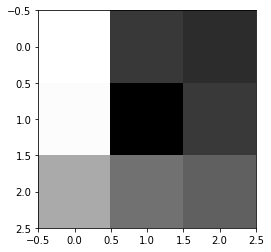

In [72]:
# Plotting the first kernel
plt.imshow(kernels[:,:,0,0], cmap = plt.cm.binary)

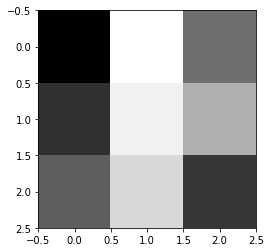

In [74]:
# Plotting the last kernel
plt.imshow(kernels[:,:,0,-1], cmap = plt.cm.binary)

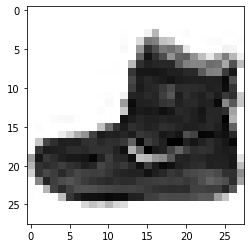

In [104]:
# Plotting the first image
plt.imshow(train_images[0], cmap = plt.cm.binary)

In [109]:
# Defining a function to compute the kernel responses
def kernel_response(image, kernel):
    convolution = np.zeros((26,26))

    for i in range(26):
        for j in range(26):
            window = image[i:i+3, j:j+3]
            convolution[i,j] = np.sum(window*kernel)
    return convolution


Let's display the kernel response for the first image using the first and last kernels and then a few others

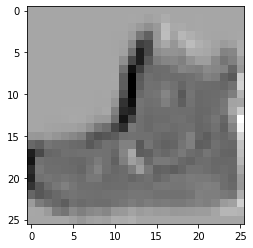

In [112]:
image = train_images[0]
kernel = kernels[:,:,0,0]
plt.imshow(kernel_response(image, kernel), cmap = plt.cm.binary)

The flap and the front of the boot are emphasized

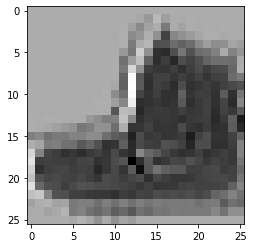

In [113]:
kernel = kernels[:,:,0,-1]
plt.imshow(kernel_response(image, kernel), cmap = plt.cm.binary)

The body of the boot is emphasized

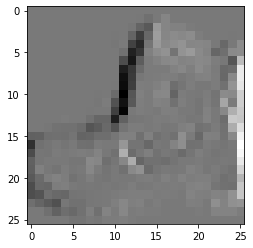

In [114]:
kernel = kernels[:,:,0, 50]
plt.imshow(kernel_response(image, kernel), cmap = plt.cm.binary)

The flap is emphasized

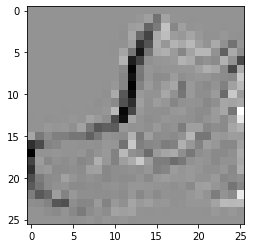

In [115]:
kernel = kernels[:,:,0,70]
plt.imshow(kernel_response(image, kernel), cmap = plt.cm.binary)

The flap and the tip of the boot are emphasized much more distinctly than in the first kernel.

Try input transformations.
See how the same kernel responds to different apparel types.